# 导入库还有下载nltk语料库

In [1]:
import re
import pandas as pd
import numpy as np  
#import os
#import inspect
from tqdm import trange
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem.lancaster import LancasterStemmer
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from time import time
nltk.download('all')

# 预处理部分

In [66]:
doc_path=r"D:\HSBC\进修\Projects\毕业项目\20news-bydate\20news-bydate-train"
All_Folders=os.listdir(r'D:\HSBC\进修\Projects\毕业项目\20news-bydate\20news-bydate-train')

#nltk.download('all')
stop_list=list(stopwords.words('english'))

alphab_list=[chr(i) for i in range(97,123)]

up_alphab_list=[x.upper() for x in alphab_list]

alphab_list.extend(up_alphab_list)

In [67]:
'''---大小写26个字母均去除---'''
stop_list.extend(alphab_list)

'''---分词性方便词性还原---'''
def pos_convert(pos_tag_label):
    if pos_tag_label.lower()[0]=='r':
        return wn.ADV
    elif pos_tag_label.lower()[0]=='j':
        return wn.ADJ
    elif pos_tag_label.lower()[0]=='n':
        return wn.NOUN
    elif pos_tag_label.lower()[0]=='v':
        return wn.VERB
    else:
        return wn.VERB

'''---清洗+分词+词性还原+词干提取---'''
def Clean_Token_Lemma_Stem(sub_doc_path,doc_name):
    txt=open(sub_doc_path+"\\"+doc_name,"rb+").read()
    txt=txt.lower()
    txt=txt.decode("utf-8","ignore")
    #txt=str(txt)
    txt=re.sub(r"[^a-zA-Z]", " ", txt)
    words=nltk.word_tokenize(txt)
    words=[w for w in words if w not in stop_list]
    '''---lemma---'''
    POS=pos_tag(words)
    
    lemmed = [WordNetLemmatizer().lemmatize(pair[0], pos=pos_convert(pair[1])) for pair in POS]
    
    stemmed = [LancasterStemmer().stem(w) for w in lemmed]
    
    return stemmed

# 开始预处理并合并训练集和测试集

In [68]:
X = []
y = []
for folder_inx in trange(len(All_Folders)):
    folder=All_Folders[folder_inx]
    sub_doc_path=doc_path+"\\"+folder
    All_Docs=os.listdir(sub_doc_path)
    for doc in All_Docs:
        words=list(set(Clean_Token_Lemma_Stem(sub_doc_path,doc)))
        join_words=' '.join(words)
        X.append(join_words)
        y.append(folder)
        
'''---测试部分---'''
test_doc_path=r"D:\HSBC\进修\Projects\毕业项目\20news-bydate\20news-bydate-test"
Test_All_Folders=os.listdir(r'D:\HSBC\进修\Projects\毕业项目\20news-bydate\20news-bydate-test')

#Test_X = []
#Test_y = []
for folder_inx in trange(len(Test_All_Folders)):
    folder=Test_All_Folders[folder_inx]
    sub_doc_path=test_doc_path+"\\"+folder
    All_Docs=os.listdir(sub_doc_path)
    for doc in All_Docs:
        words=list(set(Clean_Token_Lemma_Stem(sub_doc_path,doc)))
        join_words=' '.join(words)
        X.append(join_words)
        y.append(folder)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:57<00:00, 23.86s/it]


In [69]:
dic={'doc':X,'label':y}

output=pd.DataFrame(dic)

output.to_csv('./output_stemmed.csv')#only applicable for "join"

# 开始训练模型(批改老师最好从此开始运行)

In [ ]:
output=pd.read_csv('./output_stemmed.csv')#已经在BOW_SVM中预处理好的文本数据

X=output['doc'].tolist()
y=output['label'].tolist()

In [5]:
le = LE()

tfv = TfidfVectorizer()

X=tfv.fit_transform(X)
y=le.fit_transform(y)

trainx, testx, trainy, testy = tts(X, y, test_size=.3, random_state=42)

In [10]:
start=time()
clf = SVC(kernel='linear')
clf.fit(trainx,trainy)

y_pred=clf.predict(testx)

accuracy_score(testy,y_pred)

end=time()

print("SVC:", clf.score(testx, testy))
print("training and test time:{:.2f}s".format(end-start))

SVC: 0.9131741821396994
training and test time:215.78s


# 敏感性分析

In [12]:
def sen_test(test_split):
    print("test set size is:", test_split)
    trainx, testx, trainy, testy = tts(X, y, test_size=test_split, random_state=42)
    C_list=[1,5,10,20,50,100]
    for i in C_list:
        
        clf = SVC(C=i,kernel='linear')
        
        clf.fit(trainx,trainy)

        y_pred=clf.predict(testx)

        accuracy_score(testy,y_pred)
        
        print("SVC:", clf.score(testx, testy))
        #print("test_split=", test_split)
        print("C=", i)
        
        
        print("\n"*2)

In [13]:
test_split_list=[0.1,0.2,0.3]
start=time()
for ts in test_split_list:
    sen_test(ts)
end=time()
print("sensitive test time:{:.2f}s".format(end-start))

test set size is: 0.1
SVC: 0.9183023872679045
C= 1



SVC: 0.9183023872679045
C= 5



SVC: 0.9183023872679045
C= 10



SVC: 0.9183023872679045
C= 20



SVC: 0.9183023872679045
C= 50



SVC: 0.9177718832891246
C= 100



test set size is: 0.2
SVC: 0.9159151193633952
C= 1



SVC: 0.9180371352785146
C= 5



SVC: 0.9172413793103448
C= 10



SVC: 0.916710875331565
C= 20



SVC: 0.9161803713527852
C= 50



SVC: 0.916445623342175
C= 100



test set size is: 0.3
SVC: 0.9131741821396994
C= 1



SVC: 0.9128205128205128
C= 5



SVC: 0.9121131741821397
C= 10



SVC: 0.9121131741821397
C= 20



SVC: 0.9117595048629531
C= 50



SVC: 0.9119363395225464
C= 100



sensitive test time:5022.59s


# 简单可视化

In [43]:
import matplotlib.pyplot as plt

参数C

In [59]:
first=[0.9183,0.9183,0.9183,0.9183,0.9183,0.9178]
second=[0.9159,0.918,0.9172,0.9167,0.9161,0.9164]
third=[0.9132,0.9128,0.9121,0.9121,0.9118,0.9119]

In [61]:
df = pd.DataFrame({ '0.1' : first,
                    '0.2' : second,
                    '0.3' : third,
                  'x':['1','5','10','20','50','100']})

In [62]:
df=df.T

In [63]:
df

,0,1,2,3,4,5
0.1,0.9183,0.9183,0.9183,0.9183,0.9183,0.9178
0.2,0.9159,0.918,0.9172,0.9167,0.9161,0.9164
0.3,0.9132,0.9128,0.9121,0.9121,0.9118,0.9119
x,1,5,10,20,50,100


In [64]:
col=['1','5','10','20','50','100']

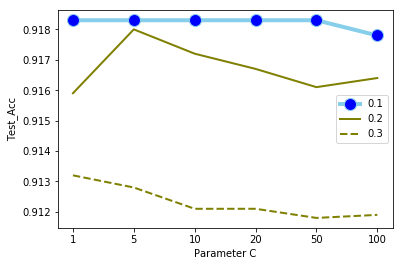

In [65]:
plt.plot( col, first, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( col, second, marker='', color='olive', linewidth=2)
plt.plot( col, third, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
plt.xlabel('Parameter C') 
plt.ylabel('Test_Acc')
plt.legend([0.1,0.2,0.3])

Max_Seq_Length

In [35]:
fist=[0.8435,0.8535,0.8551,0.8546,0.8568]
second=[0.8233,0.8401,0.8448,0.8416,0.8557]
third=[0.8152,0.8345,0.8304,0.8398,0.8311]

In [47]:
df = pd.DataFrame({ '0.1' : fist,
                    '0.2' : second,
                    '0.3' : third,
                  'x':['100','150','200','250','300']})

In [48]:
df=df.T

In [49]:
df

,0,1,2,3,4
0.1,0.8435,0.8535,0.8551,0.8546,0.8568
0.2,0.8233,0.8401,0.8448,0.8416,0.8557
0.3,0.8152,0.8345,0.8304,0.8398,0.8311
x,100,150,200,250,300


In [52]:
col=['100','150','200','250','300']

In [50]:
df.columns=['100','150','200','250','300']

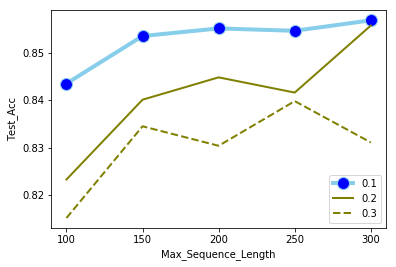

In [55]:
plt.plot( col, fist, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( col, second, marker='', color='olive', linewidth=2)
plt.plot( col, third, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
plt.xlabel('Max_Sequence_Length') 
plt.ylabel('Test_Acc')
plt.legend([0.1,0.2,0.3])